<a href="https://colab.research.google.com/github/Shallom12/Autonomous-driving-of-Chungnam-Human-Resources-Development-Institute/blob/main/yolo%ED%99%9C%EC%9A%A9_%EC%9E%90%EB%8F%99%EC%B0%A8_%EC%98%81%EC%83%81%EC%9D%B8%EC%8B%9D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 18.5 MB/s eta 0:00:00


In [ ]:
!pip install yt-dlp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.3/174.3 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 50.7 MB/s eta 0:00:00


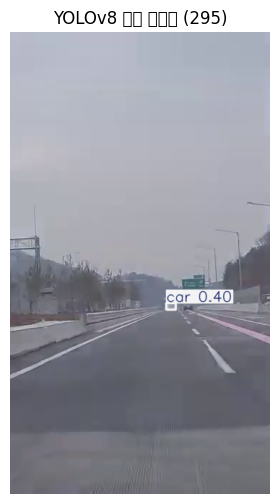

✅ 영상 추론 종료, 저장 파일: output_with_yolo.mp4


In [ ]:
import tempfile
import yt_dlp
import cv2
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
from ultralytics import YOLO

def play_and_save_youtube_with_yolo(youtube_url, skip_frames=5, output_filename="output_with_yolo.mp4", max_duration=10):
    """
    max_duration: 최대 처리 시간(초)
    """
    ydl_opts = {
        'format': 'mp4/best[height<=480]',
        'outtmpl': tempfile.gettempdir() + '/temp_video.%(ext)s',
        'quiet': True,
    }

    try:
        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
            print("⬇️ 유튜브 영상 다운로드 중...")
            info = ydl.extract_info(youtube_url, download=True)
            video_path = ydl.prepare_filename(info)

            print(f"🎥 영상 제목: {info['title']}")

            cap = cv2.VideoCapture(video_path)
            fps = cap.get(cv2.CAP_PROP_FPS)
            frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

            max_frames = int(fps * max_duration)
            print(f"⏱ 최대 {max_duration}초 (약 {max_frames} 프레임) 처리")

            fourcc = cv2.VideoWriter_fourcc(*'mp4v')
            out = cv2.VideoWriter(output_filename, fourcc, fps / skip_frames, (frame_width, frame_height))

            frame_num = 0
            processed_frames = 0

            # Load YOLOv8 model
            model = YOLO('yolov8n.pt')

            while True:
                ret, frame = cap.read()
                if not ret:
                    break
                if frame_num >= max_frames:
                    break

                if frame_num % skip_frames == 0:
                    results = model.predict(frame, imgsz=640, verbose=False)[0]
                    annotated_frame = results.plot()
                    out.write(annotated_frame)

                    clear_output(wait=True)
                    plt.figure(figsize=(10, 6))
                    plt.imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))
                    plt.title(f"YOLOv8 추론 프레임 ({frame_num})")
                    plt.axis('off')
                    plt.show()

                    time.sleep(0.1)

                frame_num += 1

            cap.release()
            out.release()
            os.remove(video_path)
            print(f"✅ 영상 추론 종료, 저장 파일: {output_filename}")

    except Exception as e:
        print(f"❌ 오류 발생: {e}")

# 실행
youtube_url = input("유튜브 영상 URL 입력: ")
play_and_save_youtube_with_yolo(youtube_url, skip_frames=5, max_duration=10)

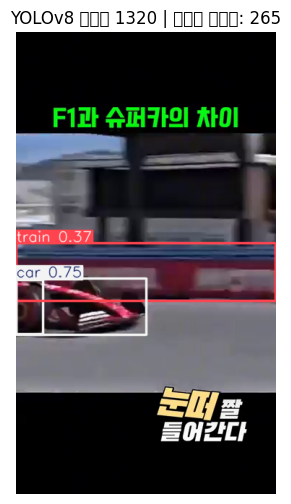

✅ 처리 완료! 저장된 파일: output_with_yolo.mp4
267 프레임을 29.1초 동안 처리
🧹 임시 영상 파일 정리 완료


In [ ]:
import tempfile
import yt_dlp
import cv2
import os
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
from ultralytics import YOLO
import numpy as np

def play_and_save_youtube_with_yolo(youtube_url, skip_frames=5, output_filename="output_with_yolo.mp4", max_duration=180):
    """
    유튜브 영상을 YOLOv8로 처리하여 자율주행 객체 탐지 후 영상 저장

    Args:
        youtube_url (str): 유튜브 영상 URL
        skip_frames (int): 처리 간격 프레임 수
        output_filename (str): 출력 영상 파일명
        max_duration (int): 최대 처리 시간(초), 기본값 3분(180초)
    """
    # 출력 파일 경로 확인
    output_dir = os.path.dirname(output_filename) or "."
    if not os.access(output_dir, os.W_OK):
        print(f"❌ 출력 디렉토리({output_dir})에 쓰기 권한이 없습니다.")
        return

    # YOLO 모델 초기화
    try:
        model = YOLO('yolov8n.pt')
    except Exception as e:
        print(f"❌ YOLO 모델 로딩 실패: {e}")
        return

    ydl_opts = {
        'format': 'mp4/best[height<=720]',  # 쇼츠 영상에 적합한 최대 720p
        'outtmpl': os.path.join(tempfile.gettempdir(), 'temp_video.%(ext)s'),
        'quiet': True,
    }

    video_path = None
    cap = None
    out = None

    try:
        # 영상 다운로드
        with yt_dlp.YoutubeDL(ydl_opts) as ydl:
            print("⬇️ 유튜브 영상 다운로드 중...")
            info = ydl.extract_info(youtube_url, download=True)
            video_path = ydl.prepare_filename(info)
            print(f"🎥 영상 제목: {info['title']}")

        # 영상 캡처 열기
        cap = cv2.VideoCapture(video_path)
        if not cap.isOpened():
            raise Exception("영상 파일 열기 실패")

        fps = cap.get(cv2.CAP_PROP_FPS)
        frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

        if frame_width == 0 or frame_height == 0:
            raise Exception("잘못된 영상 크기")

        max_frames = int(fps * max_duration)
        print(f"⏱ 최대 {max_duration}초 (~{max_frames} 프레임) 처리")

        # 비디오 라이터 초기화 (H.264 우선, 실패 시 mp4v 폴백)
        fourcc = cv2.VideoWriter_fourcc(*'avc1')
        out = cv2.VideoWriter(output_filename, fourcc, fps / skip_frames,
                            (frame_width, frame_height))

        if not out.isOpened():
            print("⚠️ H.264 코덱 실패, mp4v 코덱으로 재시도")
            fourcc = cv2.VideoWriter_fourcc(*'mp4v')
            out = cv2.VideoWriter(output_filename, fourcc, fps / skip_frames,
                                (frame_width, frame_height))
            if not out.isOpened():
                raise Exception(f"비디오 라이터 초기화 실패: 코덱 문제 또는 출력 경로({output_filename}) 확인 필요")

        frame_num = 0
        processed_frames = 0
        start_time = time.time()

        while True:
            ret, frame = cap.read()
            if not ret or frame_num >= max_frames:
                break

            if frame_num % skip_frames == 0:
                # YOLO로 프레임 처리
                results = model.predict(frame, imgsz=640, verbose=False)[0]
                annotated_frame = results.plot()

                # 출력 영상에 프레임 저장
                out.write(annotated_frame)
                processed_frames += 1

                # 진행 상황 표시 (짧은 쇼츠 영상에 맞게 자주 표시)
                if processed_frames % 5 == 0:  # 5프레임마다 표시
                    clear_output(wait=True)
                    plt.figure(figsize=(10, 6))
                    plt.imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))
                    plt.title(f"YOLOv8 프레임 {frame_num} | 처리된 프레임: {processed_frames}")
                    plt.axis('off')
                    plt.show()

                    time.sleep(0.01)

            frame_num += 1

            # 진행 상황 업데이트 (5초마다)
            if frame_num % (fps * 5) == 0:
                elapsed = time.time() - start_time
                progress_percent = (frame_num / max_frames) * 100
                print(f"진행: {frame_num}/{max_frames} 프레임 ({progress_percent:.1f}%) | 경과 시간: {elapsed:.1f}초")

        print(f"✅ 처리 완료! 저장된 파일: {output_filename}")
        print(f"{processed_frames} 프레임을 {time.time() - start_time:.1f}초 동안 처리")

    except Exception as e:
        print(f"❌ 오류 발생: {e}")

    finally:
        # 리소스 정리
        if cap is not None:
            cap.release()
        if out is not None:
            out.release()
        if video_path and os.path.exists(video_path):
            try:
                os.remove(video_path)
                print("🧹 임시 영상 파일 정리 완료")
            except Exception as e:
                print(f"⚠️ 임시 파일 삭제 실패: {e}")

# 실행
if __name__ == "__main__":
    youtube_url = "https://youtube.com/shorts/rzxxZpbnwjY?si=41gaWyqhM3F3VPNW"
    play_and_save_youtube_with_yolo(youtube_url, skip_frames=5, max_duration=180)

In [ ]:
import pandas as pd
import plotly.express as px

# 데이터 로드 (가정: 처리된 데이터 사용)
# 실제 환경에서는 데이터 파일을 읽어오는 코드로 대체 가능
data = pd.read_csv('/content/sample_data/titanic.csv')  # 예시 파일 경로

# 나이 분포 히스토그램 생성
fig = px.histogram(data, x='Age', nbins=30, title='타이타닉 승객 나이 분포',
                   labels={'Age': '나이', 'count': '승객 수'},
                   template='plotly_white')

# 인터랙티브 기능 및 레이아웃 설정
fig.update_layout(
    xaxis_title='나이',
    yaxis_title='승객 수',
    bargap=0.1,  # 막대 간 간격
    hovermode='x'  # 마우스 오버 시 X축 기준 정보 표시
)

# HTML 파일로 저장
fig.write_html('titanic_age_distribution.html')

# 시각화 출력 (Jupyter 환경에서 확인 가능)
fig.show()

In [ ]:
import pandas as pd
import plotly.express as px

# 데이터 로드 (가정: titanic_processed.csv 파일 사용)
data = pd.read_csv('/content/sample_data/titanic.csv')

# 생존 여부에 따른 나이 분포 히스토그램 생성
fig = px.histogram(data, x='Age', color='Survived', nbins=30, opacity=0.7,
                   title='생존자와 사망자의 나이 분포 비교',
                   labels={'Age': '나이', 'Survived': '생존 여부'},
                   template='plotly_white')

# 레이아웃 설정
fig.update_layout(
    xaxis_title='나이',
    yaxis_title='승객 수',
    bargap=0.1,
    hovermode='x'
)

# HTML 파일로 저장
fig.write_html('titanic_age_survival_distribution.html')

# 시각화 출력 (Jupyter 환경에서 확인 가능)
fig.show()

In [ ]:
import pandas as pd
import plotly.express as px

# 데이터 로드
data = pd.read_csv('/content/sample_data/titanic.csv')

# 성별별 생존자 수 집계
survival_by_sex = data.groupby(['Sex', 'Survived']).size().reset_index(name='Count')

# 막대 그래프 생성
fig = px.bar(survival_by_sex, x='Sex', y='Count', color='Survived',
             title='성별에 따른 생존 여부',
             labels={'Sex': '성별', 'Count': '승객 수', 'Survived': '생존 여부'},
             template='plotly_white')

# 레이아웃 설정
fig.update_layout(
    xaxis_title='성별',
    yaxis_title='승객 수',
    barmode='group'
)

# HTML 파일로 저장
fig.write_html('titanic_sex_survival.html')

# 시각화 출력
fig.show()

In [ ]:
import pandas as pd
import plotly.figure_factory as ff

# 데이터 로드
data = pd.read_csv('/content/sample_data/titanic.csv')

# 숫자형 컬럼 선택
numeric_cols = ['Age', 'SibSp', 'Parch', 'Fare']
corr_matrix = data[numeric_cols].corr()

# 히트맵 생성
fig = ff.create_annotated_heatmap(
    z=corr_matrix.values,
    x=list(corr_matrix.columns),
    y=list(corr_matrix.index),
    annotation_text=corr_matrix.round(2).values,
    colorscale='RdBu',
    showscale=True
)

# 레이아웃 설정
fig.update_layout(
    title='주요 변수 간 상관관계 히트맵',
    xaxis_title='변수',
    yaxis_title='변수'
)

# HTML 파일로 저장
fig.write_html('titanic_correlation_heatmap.html')

# 시각화 출력
fig.show()